<h1>Sieci neuronowe - ćwiczenie 5</h1>

In [2]:
!pip install torch torchvision

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassF1Score, MulticlassRecall

In [4]:
torch.cuda.is_available() # check if torch is available to use GPU

False

In [5]:
# Def subset from whole dataset
def get_subset(data: torchvision.datasets.mnist.FashionMNIST, percent: int) -> torchvision.datasets.mnist.FashionMNIST:
    choices = np.random.choice(len(data), size=(int(len(data) * (percent / 100)),), replace=False) 
    return torch.utils.data.Subset(data, choices)

In [6]:
train_set = torchvision.datasets.FashionMNIST('path', download = True, train = True, transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST('path', download = True, train = False, transform = transforms.Compose([transforms.ToTensor()]))


In [7]:
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)

In [8]:
def lable_name(label: torch.Tensor):
    result = ""
    match label:
        case 0:
            result = "T-shirt/top"
        case 1:
            result = "Trouser"
        case 2:
            result = "Pullover"
        case 3:
            result = "Dress"
        case 4:
            result = "Coat"
        case 5:
            result = "Sandal"
        case 6:
            result = "Shirt"
        case 7:
            result = "Sneaker"
        case 8:
            result = "Bag"
        case 9:
            result = "Ankle boot"
    return result
            

Trouser, T-shirt/top, Trouser, T-shirt/top, Shirt, Dress, Trouser, Shirt, Coat, Sneaker, Pullover, Ankle boot, Shirt, Trouser, Dress, Sandal, 

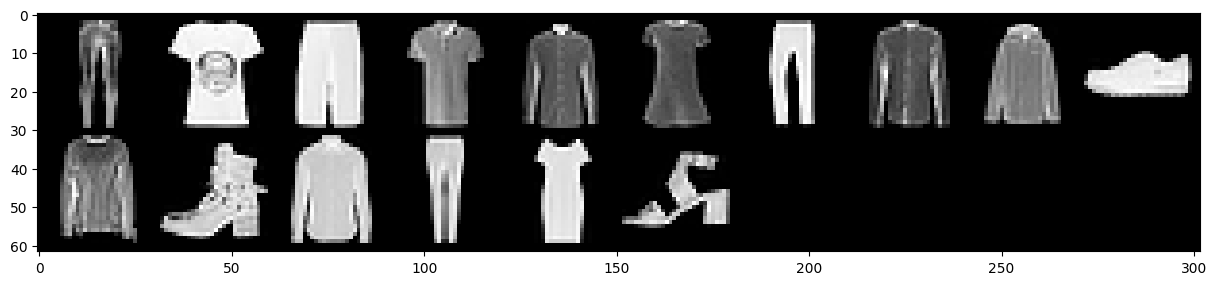

In [9]:
sample_images, sample_labels = next(iter(data_loader_train))
grid = torchvision.utils.make_grid(sample_images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

for _, label in enumerate(sample_labels):
    print(lable_name(label), end = ", ")

In [10]:
class MultilayerNetwork(torch.nn.Module):
    def __init__(self, hidden_layers_sizes: tuple, input_size: int, output_size: int):
        super(MultilayerNetwork, self).__init__()

        self._layers = torch.nn.ModuleList()
        curr_size = input_size
        for hidden_layer_size in hidden_layers_sizes:
            layer = torch.nn.Linear(curr_size, hidden_layer_size)
            torch.nn.init.normal_(layer.weight)
            torch.nn.init.normal_(layer.bias)
            self._layers.append(layer)
            self._layers.append(torch.nn.LeakyReLU())
            curr_size = hidden_layer_size
        output_layer = torch.nn.Linear(curr_size, output_size) 
        torch.nn.init.normal_(output_layer.weight)
        torch.nn.init.normal_(output_layer.bias)
        self._layers.append(output_layer)
        self._layers.append(torch.nn.LogSoftmax(dim=1))

    def forward(self, inputs):
        x = inputs
        for layer in self._layers:
            x = x.view(x.shape[0], -1)
            x = layer(x)
        return x

In [11]:
def train_model(model: torch.nn.Module, train_set: torch.Tensor, test_set: torch.Tensor, batch_size: int, optimizer, loss, max_iter: int, learning_rate: float, output_size: int, verb=False):
    
    optimizer = optimizer(model.parameters(), lr = learning_rate) 

    losses = []
    losses_test = []

    accuracy = []
    precision = []
    f_score = []
    recalls = []

    if batch_size > len(train_set):
        batch_size = len(train_set)

    data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    metric_accuracy = MulticlassAccuracy(num_classes=output_size)
    metric_precision = MulticlassPrecision(num_classes=output_size)
    metric_f_score = MulticlassF1Score(num_classes=output_size)
    metric_recall = MulticlassRecall(num_classes=output_size)

    for index in range(max_iter): #learn for max_iter  
        curr_train_loss = 0   
        curr_test_loss = 0
        metric_accuracy.reset()
        metric_precision.reset()
        metric_f_score.reset()
        metric_recall.reset()
        
        # for each batch perform learning
        for x_train_batch, y_train_batch in data_loader_train:
            optimizer.zero_grad()
            y_pred = model(x_train_batch)
            loss_value = loss(y_pred, y_train_batch)
            loss_value.backward()
            optimizer.step()
            curr_train_loss += loss_value.item()
                
        losses.append(curr_train_loss / len(data_loader_train))

        with torch.no_grad():
            model.eval()
            for x_test_batch, y_test_batch in data_loader_test:
                test_pred = model(x_test_batch)
                loss_test_value = loss(test_pred, y_test_batch)
                curr_test_loss += loss_test_value.item()

                #calculate scores for each batch of iteration
                metric_accuracy.update(test_pred, y_test_batch)
                metric_precision.update(test_pred, y_test_batch)
                metric_f_score.update(test_pred, y_test_batch)
                metric_recall.update(test_pred, y_test_batch)

            losses_test.append(curr_test_loss / len(data_loader_test))    
            accuracy.append(metric_accuracy.compute())
            precision.append(metric_precision.compute())
            f_score.append(metric_f_score.compute())
            recalls.append(metric_recall.compute())

        if verb and index % 10 == 0:
            print("---------------------------------------------- Interation " + str(index))
            print("Train loss on " + str(index) + " iteration: ", losses[index])
            print("Test loss on " + str(index) + " iteration: ", losses_test[index])
            print("Accuracy on " + str(index) + " iteration: ", accuracy[index])
            print("Precision on " + str(index) + " iteration: ", precision[index])
            print("Recall on " + str(index) + " iteration: ", recalls[index])
            print("Fscore on " + str(index) + " iteration: ", f_score[index])
            print("----------------------------------------------\n")

    print("Result of learning process for " + str(max_iter) + " iterations")
    print("--------------------------------------------------------\n")
    print("Train loss: ", losses[-1])
    print("Test loss: ", losses_test[-1])
    print("----------------------------------------------\n")
    print("Scores")
    print("Accuracy: ", accuracy[-1])
    print("Precision: ", precision[-1])
    print("F_score: ", f_score[-1])
    print("Recall: ", recalls[-1])    
    return losses, losses_test, accuracy, f_score, recalls

In [12]:
def plot_learning(losses: list, losses_test: list, title: str, axs = None):
    if axs == None:
        plt.plot(np.arange(len(losses)), losses, label="Train Loss")
        plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        axs.plot(np.arange(len(losses)), losses, label="Train Loss")
        axs.plot(np.arange(len(losses)), losses_test, label="Test loss")
        axs.set_title(title)
        axs.legend()

<h1>Eksperymenty</h1>

In [13]:
optimizer = torch.optim.Adam
loss = torch.nn.CrossEntropyLoss()
max_iter = 100
verbose = False
train_set_6 = get_subset(train_set, 6)
test_set_6 = get_subset(test_set, 6)
learning_rate = 0.001

#1 Liczba neuronów w warstwie ukrytej
hiddenLayer_20 = (20,)
hiddenLayer_50 = (50,)

# Dwuwarstwowa sieć
hiddenLayer_20_10 = (20, 10)
hiddenLayer_50_30 = (50, 30)

#2 Rozmiar batch'a
batch_size_1 = 16
batch_size_2 = 100
batch_size_3 = 1000

#3 Liczba przykładów uczących
train_set_1 = get_subset(train_set, 1)
test_set_1 = get_subset(test_set, 1)
train_set_10 = get_subset(train_set, 10)
test_set_10 = get_subset(test_set, 10)

#4 Zaburzenie danych
train_set_gauss = torchvision.datasets.FashionMNIST('path', download = True, train = True, transform = transforms.Compose([transforms.ToTensor(), transforms.GaussianBlur(kernel_size=(7, 7))]))
test_set_gauss = torchvision.datasets.FashionMNIST('path', download = True, train = False, transform = transforms.Compose([transforms.ToTensor(), transforms.GaussianBlur(kernel_size=(7, 7))]))

train_set_gauss_6 = get_subset(train_set_gauss, 6)
test_set_gauss_6 = get_subset(test_set_gauss, 6)


In [14]:
plt.style.use('seaborn-v0_8-muted')

# options [0] -> hidden_layers, [1] -> train_set, [2] -> test_set, [3] -> output_size, [4] -> batch_size
def run_models(options: list, options_title: list):
    fig, axs = plt.subplots(1, len(options), figsize=(20, 5))
    for option_index, option in enumerate(options):
        print(options_title[option_index])
        input_size = option[1][0][0].shape[1] * option[1][0][0].shape[2] # width times height of image
        model = MultilayerNetwork(option[0], input_size, option[3])
        result = train_model(model, option[1], option[2], option[4], optimizer, loss, max_iter, learning_rate, option[3], verb=verbose)
        plot_learning(result[0], result[1], options_title[option_index], axs[option_index])


<h1>Jednowarstwowa sieć</h1>

<h2>#1 Liczba neuronów w warstwie ukrytej</h2>

Set 6% Adam lr: 0.001 hidden layer: (20,) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.29200159713625906
Test loss:  0.8338900406501795
----------------------------------------------

Scores
Accuracy:  tensor(0.7938)
Precision:  tensor(0.7999)
F_score:  tensor(0.7951)
Recall:  tensor(0.7938)
Set 6% Adam lr: 0.001 hidden layer: (50,) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.1038357123070293
Test loss:  1.5707062670078717
----------------------------------------------

Scores
Accuracy:  tensor(0.7804)
Precision:  tensor(0.7825)
F_score:  tensor(0.7789)
Recall:  tensor(0.7804)


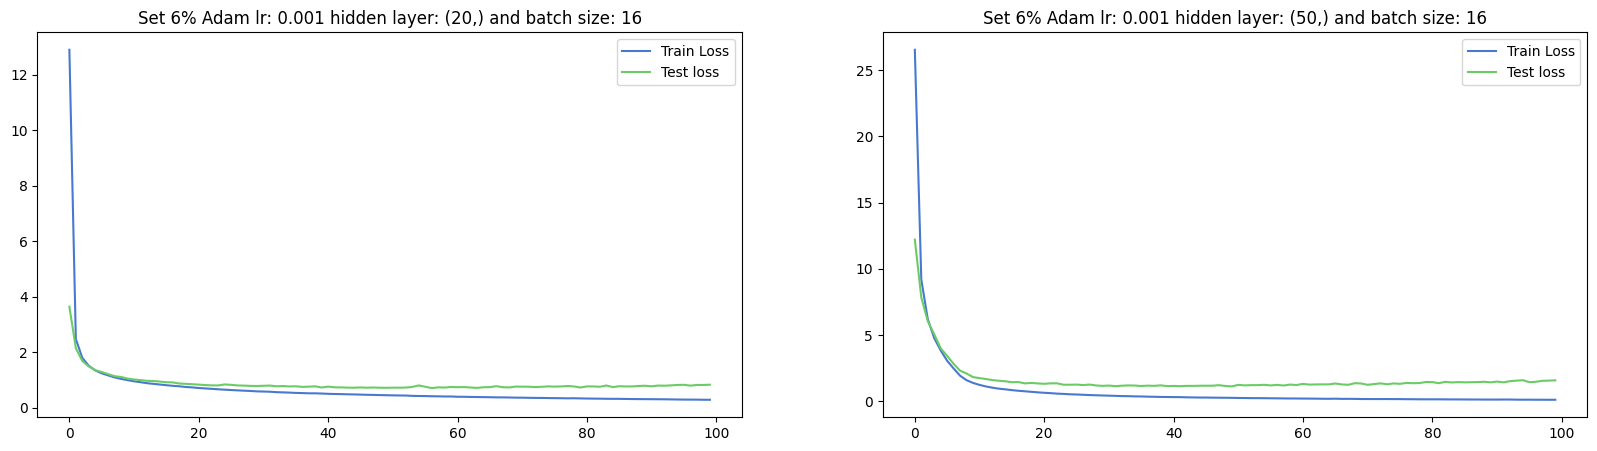

In [23]:
options_neurons_size = [[hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_50, train_set_6, test_set_6, 10, batch_size_1]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_50) + " and batch size: " + str(batch_size_1)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#2 Rozmiar batch'a</h2>

Set 6% Adam lr: 0.001 hidden layer: (20,) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.24108613659110334
Test loss:  1.0460126905849105
----------------------------------------------

Scores
Accuracy:  tensor(0.7749)
Precision:  tensor(0.7854)
F_score:  tensor(0.7792)
Recall:  tensor(0.7749)
Set 6% Adam lr: 0.001 hidden layer: (20,) and batch size: 100
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.5828319415450096
Test loss:  0.8840182423591614
----------------------------------------------

Scores
Accuracy:  tensor(0.6965)
Precision:  tensor(0.7091)
F_score:  tensor(0.6928)
Recall:  tensor(0.6965)
Set 6% Adam lr: 0.001 hidden layer: (20,) and batch size: 1000
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  1.8069463074207306
Test loss:  2.023481607437134

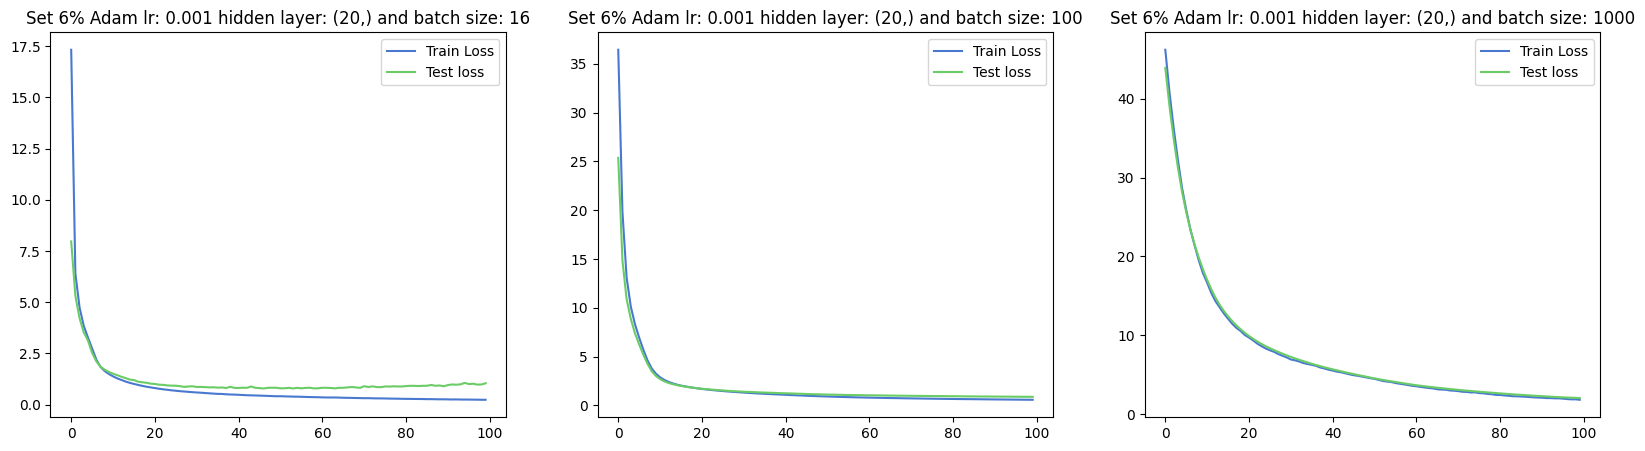

In [16]:
options_neurons_size = [[hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_2],
                        [hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_3]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_2),
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_3)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#3 Liczba przykładów uczących</h2>

Set 1% Adam lr: 0.001 hidden layer: (20,) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.4238712846448547
Test loss:  1.1701844504901342
----------------------------------------------

Scores
Accuracy:  tensor(0.7296)
Precision:  tensor(0.7419)
F_score:  tensor(0.7282)
Recall:  tensor(0.7296)
Set 6% Adam lr: 0.001 hidden layer: (20,) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.26935391867326364
Test loss:  1.2216623668607913
----------------------------------------------

Scores
Accuracy:  tensor(0.7648)
Precision:  tensor(0.7698)
F_score:  tensor(0.7652)
Recall:  tensor(0.7648)
Set 10% Adam lr: 0.001 hidden layer: (20,) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.23481494045009216
Test loss:  1.1576837573259595

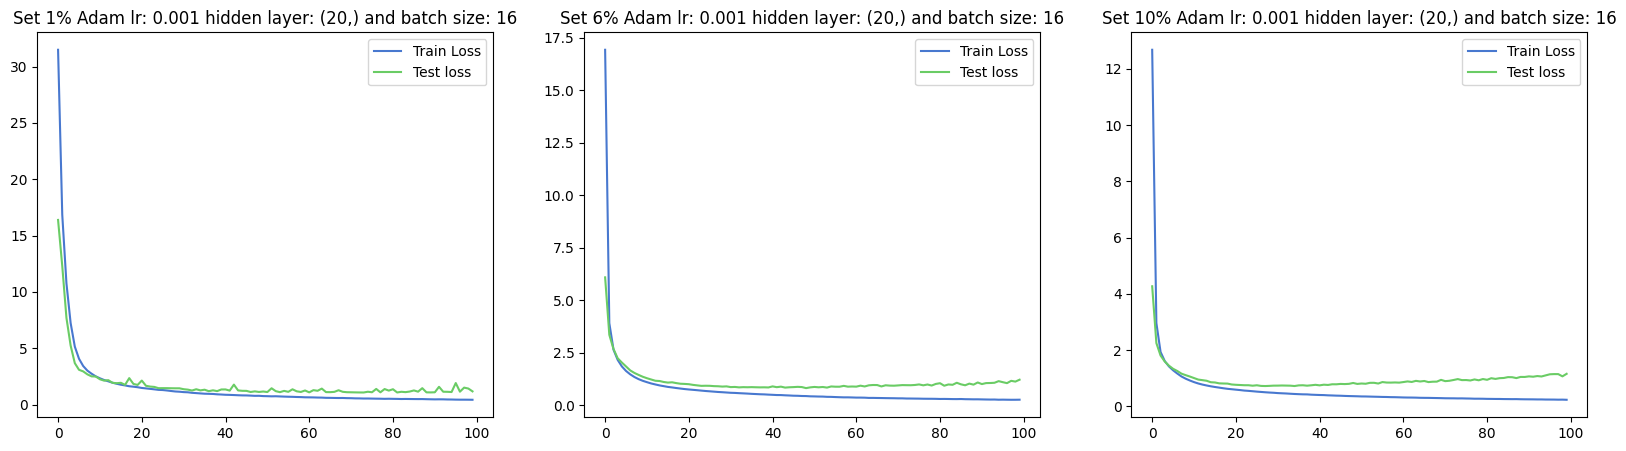

In [17]:
options_neurons_size = [[hiddenLayer_20, train_set_1, test_set_1, 10, batch_size_1], 
                        [hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1],
                        [hiddenLayer_20, train_set_10, test_set_10, 10, batch_size_1]]

options_neurons_titles = ["Set 1% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1),
                          "Set 10% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#4 Zaburzenie danych</h2>

Set 6% Adam lr: 0.001 hidden layer: (20,) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.22970321815046998
Test loss:  1.0236609289912801
----------------------------------------------

Scores
Accuracy:  tensor(0.7837)
Precision:  tensor(0.7820)
F_score:  tensor(0.7823)
Recall:  tensor(0.7837)
Test Gauss 6% Adam
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.24109096277091238
Test loss:  1.0770301156138118
----------------------------------------------

Scores
Accuracy:  tensor(0.7221)
Precision:  tensor(0.7312)
F_score:  tensor(0.7163)
Recall:  tensor(0.7221)
Full Gauss 6% Adam
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.39676876889334783
Test loss:  0.8045372272792616
----------------------------------------------

Scores
Accuracy:  tensor(0.8028)
Pr

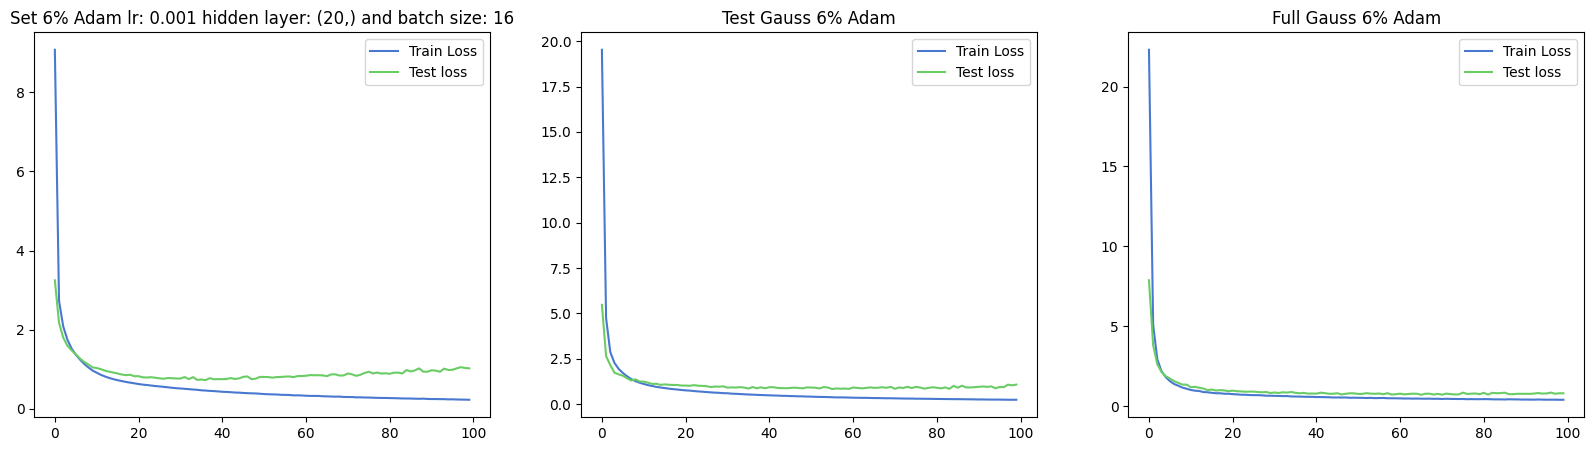

In [18]:
options_neurons_size = [[hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_20, train_set_6, test_set_gauss_6, 10, batch_size_1],
                        [hiddenLayer_20, train_set_gauss_6, test_set_gauss_6, 10, batch_size_1]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Test Gauss 6% Adam",
                          "Full Gauss 6% Adam"]

run_models(options_neurons_size, options_neurons_titles)

<h1>Dwuwartwowa sieć</h1>

<h2>#1 Liczba neuronów w warstwie ukrytej</h2>

Set 6% Adam lr: 0.001 hidden layer: (20, 10) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.3368764278623793
Test loss:  1.001213756046797
----------------------------------------------

Scores
Accuracy:  tensor(0.7706)
Precision:  tensor(0.7741)
F_score:  tensor(0.7694)
Recall:  tensor(0.7706)
Set 6% Adam lr: 0.001 hidden layer: (50, 30) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.1663755909490606
Test loss:  2.184932970294827
----------------------------------------------

Scores
Accuracy:  tensor(0.7517)
Precision:  tensor(0.7593)
F_score:  tensor(0.7542)
Recall:  tensor(0.7517)


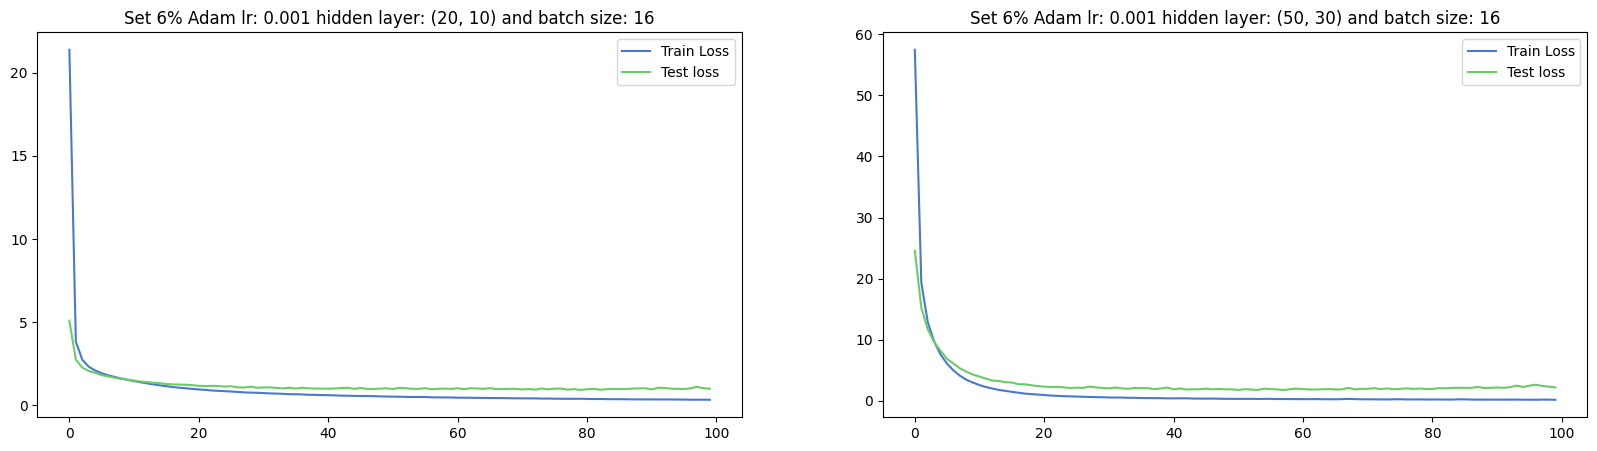

In [19]:
options_neurons_size = [[hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_50_30, train_set_6, test_set_6, 10, batch_size_1]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_50_30) + " and batch size: " + str(batch_size_1)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#2 Rozmiar batch'a</h2>

6% Adam lr: 0.001 hidden layer: (20, 10) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.3638313665944669
Test loss:  0.8484016496099924
----------------------------------------------

Scores
Accuracy:  tensor(0.7989)
Precision:  tensor(0.8058)
F_score:  tensor(0.8017)
Recall:  tensor(0.7989)
6% Adam lr: 0.001 hidden layer: (20, 10) and batch size: 100
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.95477927227815
Test loss:  1.3571951587994893
----------------------------------------------

Scores
Accuracy:  tensor(0.6528)
Precision:  tensor(0.6644)
F_score:  tensor(0.6516)
Recall:  tensor(0.6528)
6% Adam lr: 0.001 hidden layer: (20, 10) and batch size: 1000
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  4.193578839302063
Test loss:  4.933875560760498
------

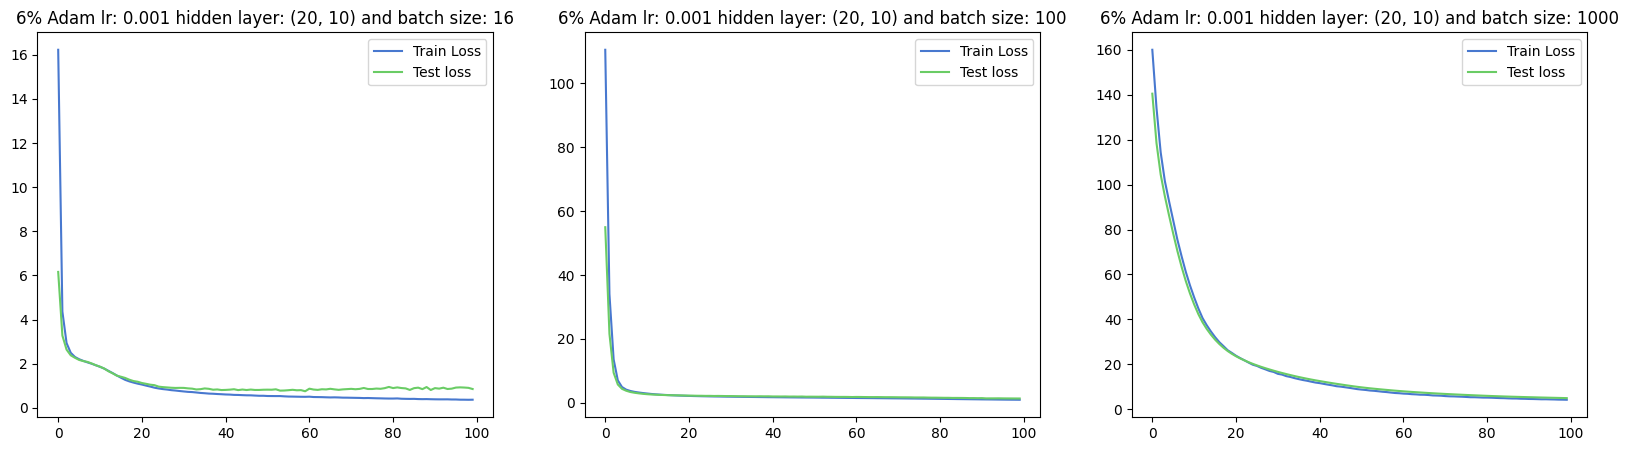

In [20]:
options_neurons_size = [[hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_2],
                        [hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_3]]

options_neurons_titles = ["6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1), 
                          "6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_2),
                          "6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_3)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#3 Liczba przykładów uczących</h2>

1% Adam lr: 0.001 hidden layer: (20, 10) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.7131069420199645
Test loss:  2.2692528877939497
----------------------------------------------

Scores
Accuracy:  tensor(0.6188)
Precision:  tensor(0.6331)
F_score:  tensor(0.6174)
Recall:  tensor(0.6188)
6% Adam lr: 0.001 hidden layer: (20, 10) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.30639735359284614
Test loss:  0.8433745840662404
----------------------------------------------

Scores
Accuracy:  tensor(0.7938)
Precision:  tensor(0.7987)
F_score:  tensor(0.7894)
Recall:  tensor(0.7938)
10% Adam lr: 0.001 hidden layer: (20, 10) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.3297486201922099
Test loss:  1.011527494335222
----

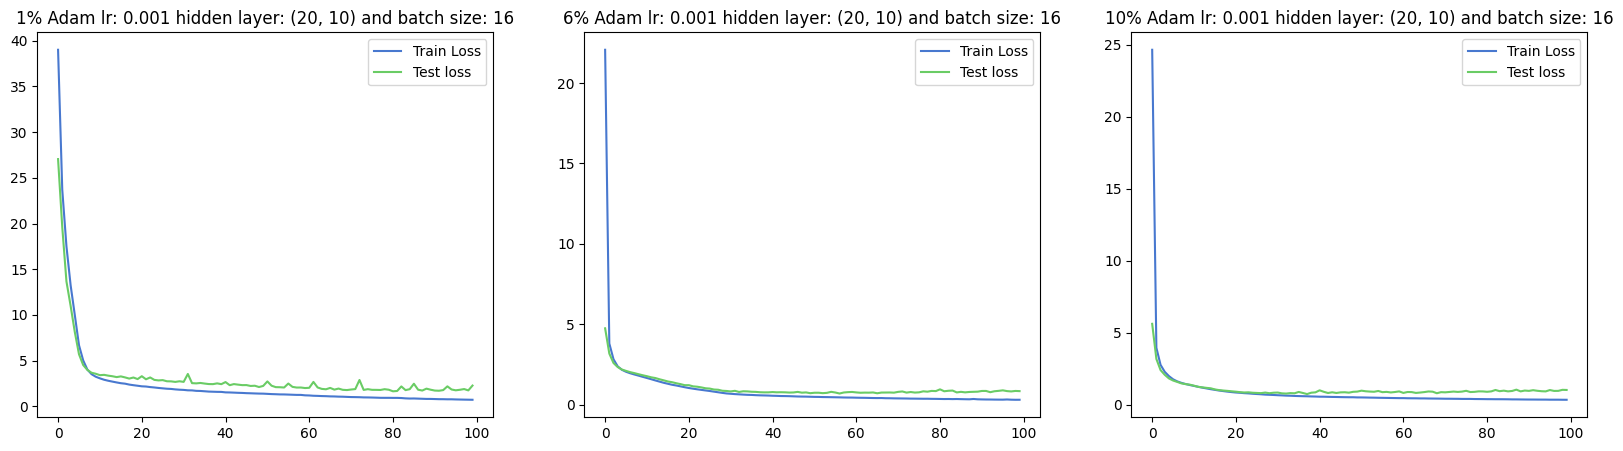

In [21]:
options_neurons_size = [[hiddenLayer_20_10, train_set_1, test_set_1, 10, batch_size_1], 
                        [hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_1],
                        [hiddenLayer_20_10, train_set_10, test_set_10, 10, batch_size_1]]

options_neurons_titles = ["1% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1), 
                          "6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1),
                          "10% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#4 Zaburzenie danych</h2>

6% Adam lr: 0.001 hidden layer: (20, 10) and batch size: 16
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.3827910033861796
Test loss:  0.8624059538307943
----------------------------------------------

Scores
Accuracy:  tensor(0.7781)
Precision:  tensor(0.7813)
F_score:  tensor(0.7779)
Recall:  tensor(0.7781)
Test Gauss 6% Adam
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.3303325768477387
Test loss:  0.8241675300033469
----------------------------------------------

Scores
Accuracy:  tensor(0.7527)
Precision:  tensor(0.7489)
F_score:  tensor(0.7425)
Recall:  tensor(0.7527)
Full Gauss 6% Adam
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.46304762966103025
Test loss:  0.7004600202566699
----------------------------------------------

Scores
Accuracy:  tensor(0.7956)
Preci

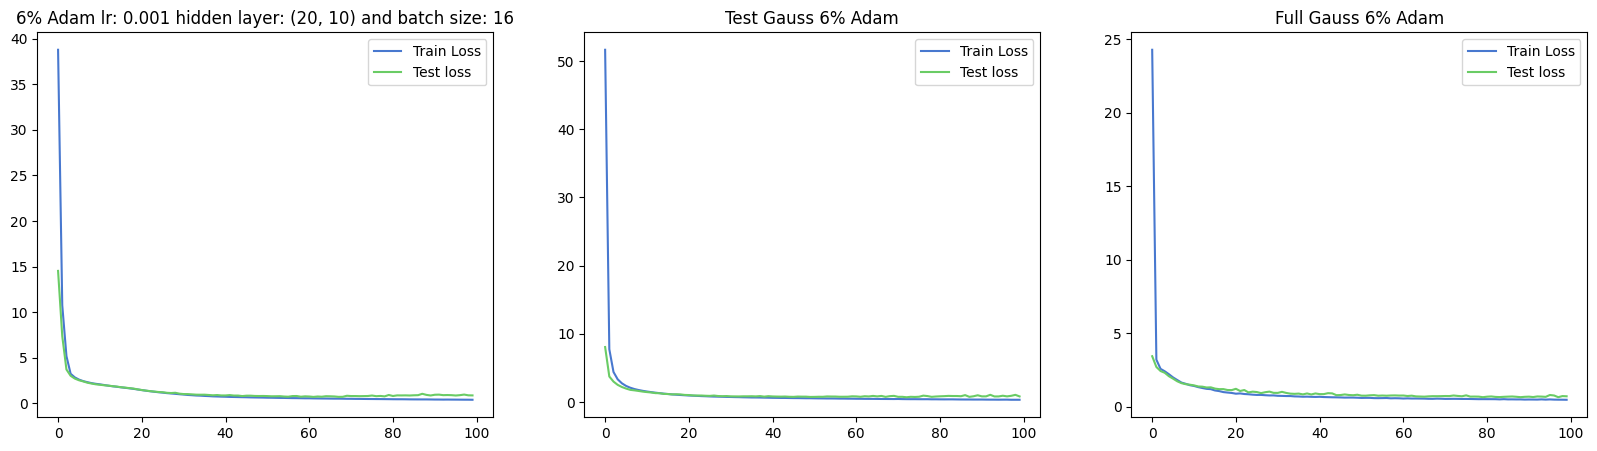

In [24]:
options_neurons_size = [[hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_20_10, train_set_6, test_set_gauss_6, 10, batch_size_1],
                        [hiddenLayer_20_10, train_set_gauss_6, test_set_gauss_6, 10, batch_size_1]]

options_neurons_titles = ["6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1), 
                          "Test Gauss 6% Adam",
                          "Full Gauss 6% Adam"]

run_models(options_neurons_size, options_neurons_titles)

<p><i>Wykonane przez Szymona Sawczuka nr indeksu 260287</i></p>